In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout
#from tensorflow.keras.utils import plot_model
#from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt

2021-07-19 21:07:51.858739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-19 21:07:51.858778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print('Devices List: ', tf.config.list_physical_devices('GPU'))
print('Is built with CUDA:', tf.test.is_built_with_cuda())

Devices List:  []
Is built with CUDA: True


2021-07-19 21:07:53.277982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-19 21:07:53.278045: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-19 21:07:53.278073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3383a395dced): /proc/driver/nvidia/version does not exist


In [3]:
# Balance the clusters

def balance_df(df1, df2, random_state = 42):
    df = (df1, df2)
    lenght = (len(df[0]), len(df[1]))
    idx = np.argmin([lenght[0], lenght[1]])
    return pd.concat([df[idx], df[1-idx].sample(lenght[idx], random_state=random_state)], axis = 0)

In [4]:
# Remove regulars expressions

import re
import string
def custom_preprocessor(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('u.s.', 'usa', text)
    text = re.sub('reuters', '', text)
    text = re.sub('can\'t', 'cant', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [5]:
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

fake_news['target'] = 0
true_news['target'] = 1

news = balance_df(fake_news, true_news)
news['text'] = news['text'].apply(custom_preprocessor)
news['title'] = news['title'].apply(custom_preprocessor)

In [6]:
from sklearn.model_selection import train_test_split

feature = 'title'
target = 'target'

X = news[[feature, target]]

X_train, X_val = train_test_split(X,random_state=42,test_size=0.2)
X_train,X_test = train_test_split(X_train,random_state=42,test_size=0.2)

In [7]:
# Save preprocessed set for future use.

X_train.to_csv('train_rnn.csv', index=False)
X_val.to_csv('validation_rnn.csv', index=False)
X_test.to_csv('test_rnn.csv', index=False)

In [8]:
train = pd.read_csv("train_rnn.csv")
validation = pd.read_csv("validation_rnn.csv")
test = pd.read_csv("test_rnn.csv")

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [10]:
maxlen = 50 # max sequence len before truncation  
batch_size = 32

In [11]:
vectorizer = TextVectorization(output_sequence_length=maxlen)
text_ds = tf.data.Dataset.from_tensor_slices(train[feature]).batch(128)
vectorizer.adapt(text_ds)

2021-07-19 21:08:10.489408: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-19 21:08:10.544184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-19 21:08:10.544919: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3696010000 Hz


In [12]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [13]:
train_feature = vectorizer(X_train[feature])
train_label = tf.convert_to_tensor(X_train[target])

validation_feature = vectorizer(X_val[feature])
validation_label = tf.convert_to_tensor(X_val[target])

test_feature = vectorizer(X_test[feature])
test_label = tf.convert_to_tensor(X_test[target])

In [14]:
max_features = len(word_index) + 1 # number of words to consider as features  

In [15]:
def make_model(max_features):
    model = Sequential()
    model.add(Embedding(max_features, 16))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(32, recurrent_dropout = 0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                #loss='binary_crossentropy',
                #metrics=['acc']
                #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=tf.metrics.SparseCategoricalAccuracy(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=tf.keras.metrics.BinaryAccuracy()
                 )
    
    return model

In [16]:
model = make_model(max_features)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          291120    
_________________________________________________________________
dense (Dense)                (None, None, 32)          544       
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [17]:
history = model.fit(train_feature, train_label,
                    epochs=6,
                    batch_size=512,
                    #validation_split=0.4
                    validation_data=(validation_feature, validation_label)
                   )

Epoch 1/6
54/54 [==============================] - 6s 66ms/step - loss: 0.5899 - binary_accuracy: 0.6501 - val_loss: 0.3742 - val_binary_accuracy: 0.8814
Epoch 2/6
54/54 [==============================] - 3s 60ms/step - loss: 0.2900 - binary_accuracy: 0.9022 - val_loss: 0.2849 - val_binary_accuracy: 0.8965
Epoch 3/6
54/54 [==============================] - 3s 60ms/step - loss: 0.1939 - binary_accuracy: 0.9344 - val_loss: 0.1402 - val_binary_accuracy: 0.9524
Epoch 4/6
54/54 [==============================] - 3s 57ms/step - loss: 0.1495 - binary_accuracy: 0.9475 - val_loss: 0.1389 - val_binary_accuracy: 0.9510
Epoch 5/6
54/54 [==============================] - 3s 59ms/step - loss: 0.1117 - binary_accuracy: 0.9616 - val_loss: 0.1289 - val_binary_accuracy: 0.9492
Epoch 6/6
54/54 [==============================] - 3s 58ms/step - loss: 0.0933 - binary_accuracy: 0.9688 - val_loss: 0.1072 - val_binary_accuracy: 0.9603


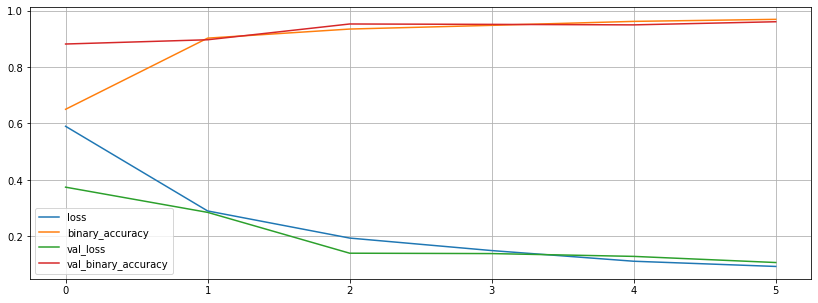

In [18]:
pd.DataFrame(history.history).plot(figsize = (14,5))
plt.grid(True)

In [19]:
evaluate_prediction = model.evaluate(test_feature, test_label)
evaluate_prediction

215/215 [==============================] - 3s 12ms/step - loss: 0.1054 - binary_accuracy: 0.9634


[0.10537861287593842, 0.9633790254592896]

In [20]:
solution = pd.DataFrame(model.predict(test_feature).round(), columns = ['predict'])
solution['predict'] = solution['predict'].apply(lambda x: int(x))

In [21]:
test_join_solution = X_test.reset_index().join(solution)
test_join_solution['delta'] = test_join_solution['predict'] - test_join_solution['target']

In [22]:
test_join_solution.groupby(['delta']).count()

,index,title,target,predict
delta,,,,
-1,104,104,104,104
0,6603,6603,6603,6603
1,147,147,147,147


In [23]:
df_confusion = pd.crosstab(test_join_solution['target'], test_join_solution['predict'])

In [24]:
df_confusion

predict,0,1
target,,
0,3302,147
1,104,3301


In [25]:
test_accuracy = 1 - (df_confusion[0][1] + df_confusion[1][0]) / df_confusion.sum().sum()
test_accuracy

0.9633790487306683